In [1]:
dependencies = [
    "kagtool",
    "kaggle",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *
from fastai.vision.all import *


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [16]:
from kagtool.datasets.kaggle_downloader import KaggleDownloader

dataset_name = 'digit-recognizer'
creds = ''

path = KaggleDownloader(dataset_name, creds).load_or_fetch_kaggle_dataset()
df = pd.read_csv(path/'train.csv')
df.head()

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
import pandas as pd
from fastai.vision.all import *
from PIL import Image

def get_image_from_pixels(row, img_size=(28, 28)):
    """
    Convert a row of pixel data to a PIL Image
    :param row: Pandas Series or array with pixel values.
    :param img_size: Tuple representing the size of the image.
    :return: PIL Image.
    """
    # Convert the row to a numpy array and reshape into image dimensions
    pixel_data = row.values.reshape(img_size)
    # Convert array to PIL Image
    return Image.fromarray(pixel_data.astype('uint8'), 'L') # 'L' mode for grayscale


In [4]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


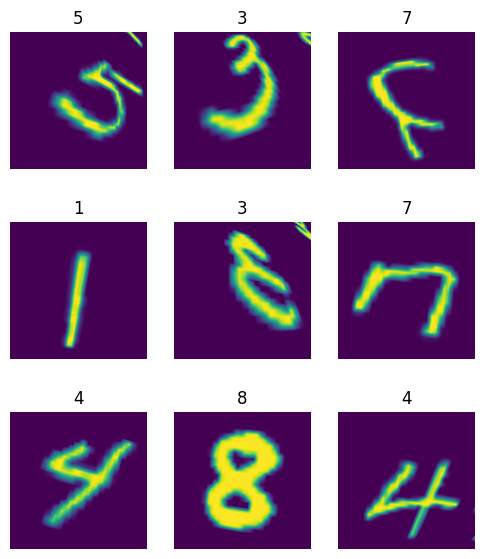

In [5]:
def get_x(row):
    if 'label' in row:
        return get_image_from_pixels(row[1:])  # Exclude the label column
    else:
        return get_image_from_pixels(row)

def get_y(row):
    return row['label']
    
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,  # Assuming get_x is defined as before
                   get_y=get_y,  # Assuming get_y is defined as before
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(128),  # Resize images
                   batch_tfms=aug_transforms(mult=2))  # Apply default augmentations, adjust as necessary
dls = dblock.dataloaders(df, bs=64)
dls.show_batch(max_n=9, figsize=(6, 7))


In [6]:
arch = resnet50

SuggestedLRs(slide=0.00363078061491251, valley=0.0012022644514217973)

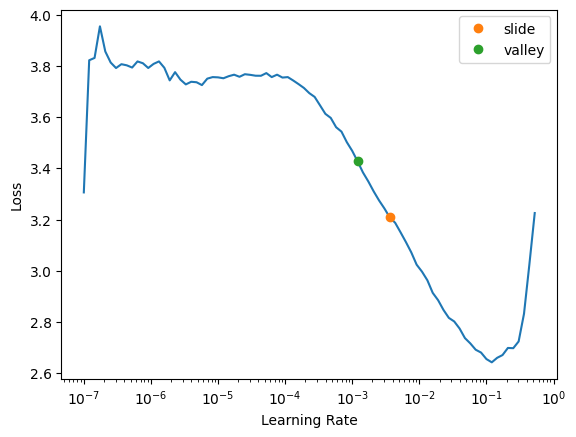

In [7]:
learn = vision_learner(dls, arch, metrics=accuracy)
learn.lr_find(suggest_funcs=(slide, valley))

In [8]:
lr=0.003
epochs=10

In [9]:
# Progressive Resizing... doesn't work
# seems like thats not how u do it, probably need to freeze layers? dunno..

# dls = dblock.dataloaders(df, bs=64, size=64)  # Start with smaller images
# learn = vision_learner(dls, arch, metrics=accuracy)
# learn.fine_tune(5, base_lr=1e-2)  # First round of training

# dls = dblock.dataloaders(df, bs=32, size=128)  # Increase image size
# learn.dls = dls
# learn.fine_tune(5, base_lr=1e-3)  # Continue training with larger images


In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [11]:
dls = dblock.dataloaders(df, bs=64, size=64)
learn = vision_learner(dls, arch, metrics=accuracy)

In [ ]:
learn.fine_tune(1, base_lr=lr)

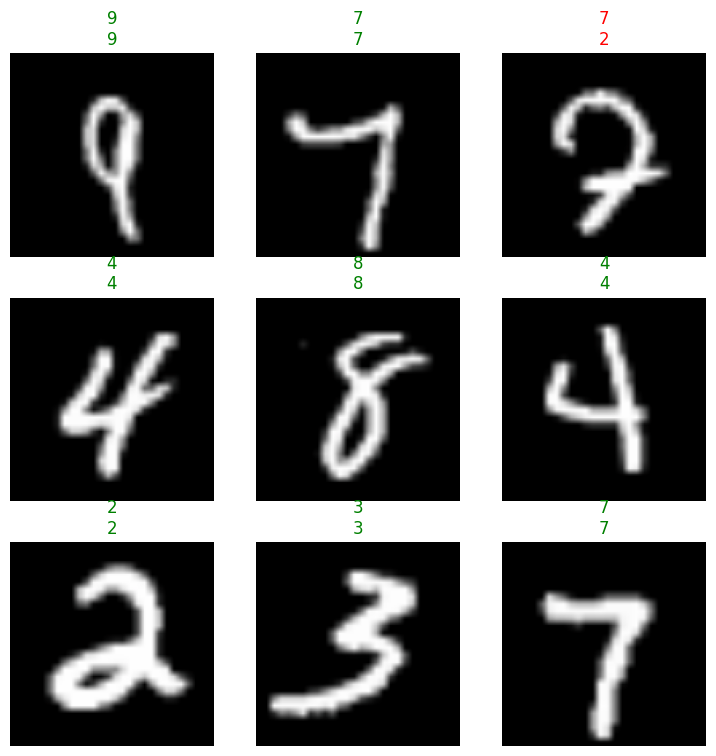

In [26]:
learn.show_results()

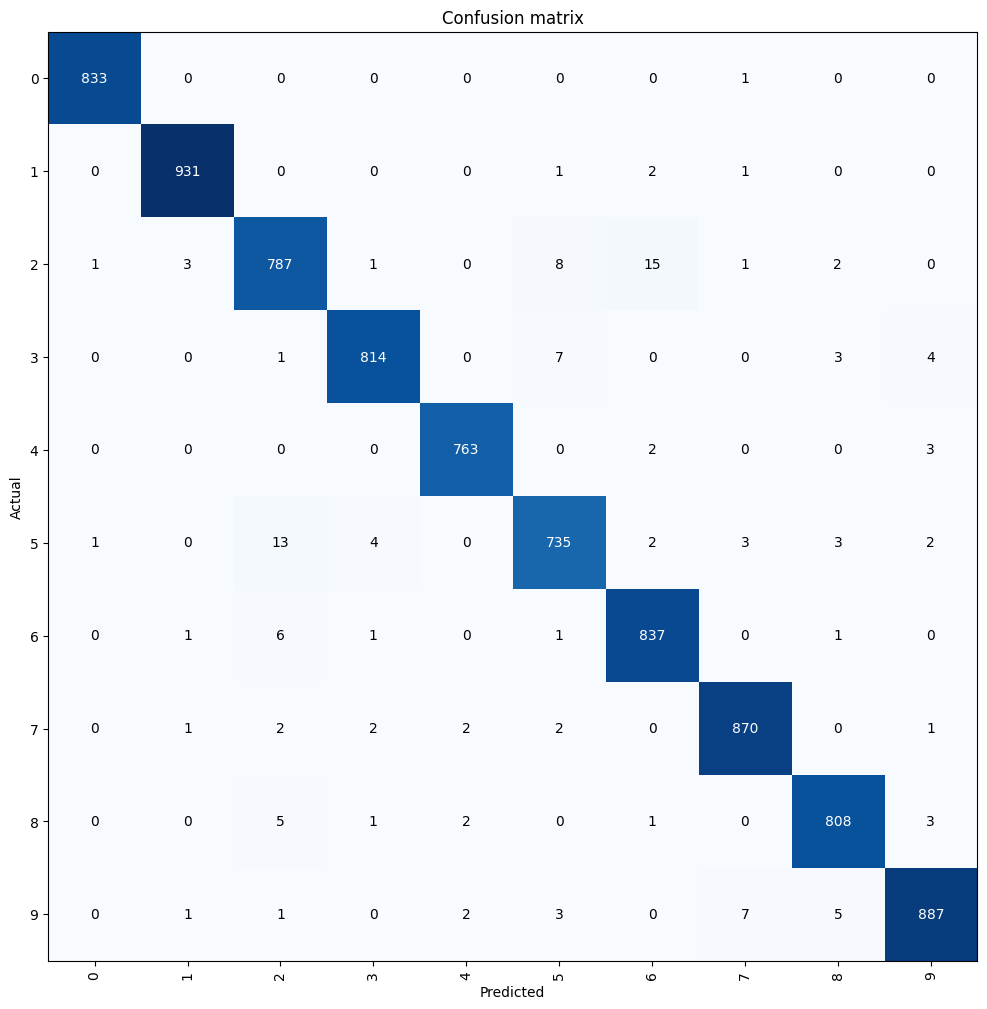

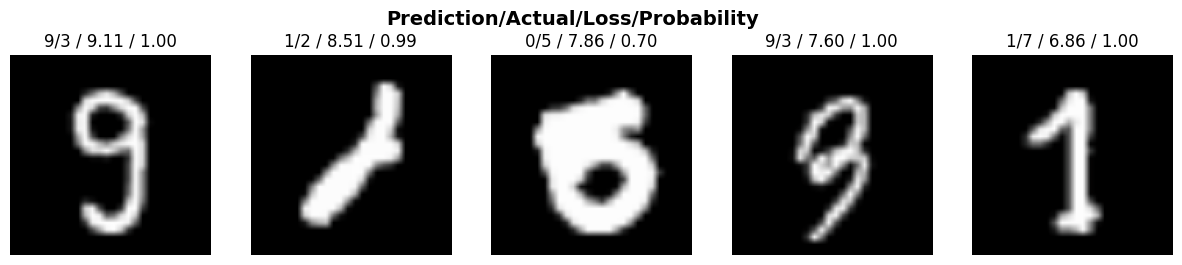

In [27]:
# Plot confusion matrix to see where the model makes mistakes
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

# Plot top losses to see the images with the highest loss
interp.plot_top_losses(5, nrows=1)

In [39]:
### Testing - Just check that we can do pred without issue (format of test and training is often different)

In [44]:
tst_df = pd.read_csv(path/'test.csv')
tst_dl = learn.dls.test_dl(tst_df)

In [45]:
preds = learn.get_preds(dl=tst_dl)[0]
preds[0].argmax()

tensor(2)

In [80]:
# first_batch = next(iter(tst_dl))
first_batch[0][0]

torch.Size([3, 128, 128])

### Ensembling

In [14]:
def ensemble():
    dls = dblock.dataloaders(df, bs=64, size=64)  # Start with smaller images
    learn = vision_learner(dls, arch, metrics=accuracy)
    # with learn.no_bar(),learn.no_logging(): learn.fine_tune(epochs, base_lr=lr)
    learn.fine_tune(epochs, base_lr=lr)
    return learn.get_preds(dl=tst_dl)[0]


learns = [ensemble() for _ in range(5)]
ens_preds = torch.stack(learns).mean(0)

epoch,train_loss,valid_loss,accuracy,time
0,0.924664,0.367723,0.876905,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.209967,0.093766,0.970595,00:55
1,0.127773,0.071646,0.976548,00:55
2,0.101053,0.041297,0.987024,00:55
3,0.081791,0.052603,0.984643,00:55
4,0.064537,0.044766,0.986786,00:55
5,0.052234,0.030001,0.990476,00:55
6,0.044064,0.031960,0.990833,00:55
7,0.039627,0.026416,0.993214,00:55
8,0.026264,0.024879,0.992381,00:56
9,0.022898,0.024152,0.993452,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.906762,0.380157,0.863929,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.207284,0.083404,0.971786,00:55
1,0.129108,0.062668,0.980357,00:55
2,0.102815,0.052785,0.983810,00:55
3,0.076683,0.048869,0.984881,00:55
4,0.061340,0.029223,0.991429,00:55
5,0.056504,0.029010,0.991071,00:55
6,0.045982,0.034418,0.990357,00:55
7,0.039848,0.026252,0.992500,00:55
8,0.032203,0.023297,0.992738,00:55
9,0.022524,0.023670,0.992738,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.927250,0.407659,0.859524,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.210161,0.084193,0.973690,00:55
1,0.113134,0.056373,0.983214,00:55
2,0.112281,0.046073,0.987381,00:55
3,0.088426,0.035650,0.988929,00:55
4,0.067130,0.041323,0.987738,00:56
5,0.063505,0.029851,0.990833,00:56
6,0.036653,0.031854,0.990833,00:55
7,0.035466,0.024825,0.992262,00:55
8,0.026907,0.025480,0.992619,00:56
9,0.026793,0.024033,0.992857,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.910164,0.398093,0.864286,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.214264,0.086166,0.973333,00:55
1,0.127693,0.044735,0.985952,00:55
2,0.102856,0.056245,0.983691,00:55
3,0.091858,0.050792,0.984286,00:55
4,0.060156,0.050654,0.985119,00:56
5,0.056171,0.035357,0.989405,00:55
6,0.042062,0.029306,0.991310,00:56
7,0.030718,0.028184,0.991786,00:55
8,0.032598,0.024352,0.991905,00:55
9,0.021999,0.022935,0.992738,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.929906,0.377879,0.869524,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.221890,0.090917,0.970833,00:55
1,0.123749,0.064621,0.981071,00:55
2,0.114437,0.065363,0.980595,00:56
3,0.102546,0.054533,0.982619,00:55
4,0.075917,0.045225,0.986310,00:55
5,0.063061,0.038225,0.989405,00:56
6,0.050062,0.028782,0.992024,00:55
7,0.030602,0.029097,0.992024,00:55
8,0.023581,0.026016,0.992143,00:56
9,0.025854,0.026812,0.992143,00:55


In [36]:
ens_preds.shape

torch.Size([28000, 10])

In [37]:
tst_df['ImageId'] = range(1, len(tst_df) + 1)
tst_df['Label'] = torch.argmax(ens_preds, dim=1)
sub_df = tst_df[['ImageId','Label']]
sub_df.to_csv('ens_sub.csv', index=False)

!head ens_sub.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0
